In [8]:
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import yfinance as yf
import pandas as pd
import numpy as np
import sys
import os

plt.style.use('Solarize_Light2')

FIGSIZE = (30, 10)

## **Loading & cleaning data**

In [9]:
if os.path.exists("data.csv"):
    df = pd.read_csv("data.csv", index_col=0)
else:
    gold_ticker = yf.Ticker("GC=F")
    # gold_ticker = yf.Ticker("NQ=F")
    # gold_ticker = yf.Ticker("YM=F")
    df = gold_ticker.history(period="max", interval='1h')
    df.to_csv("data.csv")

df.index = pd.to_datetime(df.index, utc=True)

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)

In [10]:
bool_df = df.isna()
if not bool_df.loc[(bool_df['Close'] == True) | (bool_df['High'] == True) | (bool_df['Low'] == True) | (bool_df['Open'] == True)].empty:
    print("There is missing data")
    sys.exit("There is missing data")

## **Needed Cols**

In [11]:
WINDOW = 14

df['Mean'] = df['Close'].rolling(window=WINDOW).mean()
# df['Mean'] = df['Close'].ewm(span=WINDOW, adjust=False).mean()
df['STD'] = df['Close'].rolling(window=WINDOW).std()
df['Z-Score'] = np.where(
    abs(df['High'] - df['Mean'])  > abs(df['Mean'] - df['Low']),
    (df['High'] - df['Mean']) / df['STD'],
    (df['Low'] - df['Mean']) / df['STD']
)

df['Mean'] = df['Mean'].shift(1)
df['STD'] = df['STD'].shift(1)
df['Z-Score'] = df['Z-Score'].shift(1)

df.dropna(inplace=True)

df.head(5)

,Open,High,Low,Close,Mean,STD,Z-Score
Datetime,,,,,,,
2022-10-24 12:00:00+00:00,1654.500000,1656.000000,1651.099976,1653.599976,1658.507150,4.403068,-1.568719
2022-10-24 13:00:00+00:00,1653.599976,1658.800049,1648.400024,1655.699951,1657.778573,4.302639,-1.552210
2022-10-24 14:00:00+00:00,1655.599976,1656.099976,1648.000000,1652.300049,1657.057138,3.651714,-2.370699
2022-10-24 15:00:00+00:00,1652.300049,1656.400024,1650.699951,1656.199951,1656.371425,3.572854,-2.343064
2022-10-24 16:00:00+00:00,1656.099976,1657.000000,1653.900024,1654.900024,1656.199995,3.514806,-1.564821


## **Generate buy/sell signals**

In [12]:
HIGHER_PRICE_DEVIATION = {
    'TP': 1,
    'SL': 4,
    'ENTRY': 3
}
LOWER_PRICE_DEVIATION = {
    'TP': 1,
    'SL': 4,
    'ENTRY': 3
}
SIGNALS = {
    'BUY': 1,
    'SELL': -1
}

price_deviate_over_xSTD_filter = df['Z-Score'] > HIGHER_PRICE_DEVIATION['ENTRY']
price_deviate_under_xSTD_filter = df['Z-Score'] < -LOWER_PRICE_DEVIATION['ENTRY']

df['Signal'] = 0  # Default to hold/no position
df.loc[price_deviate_under_xSTD_filter, 'Signal'] = SIGNALS['BUY'] # Buy signal
df.loc[price_deviate_over_xSTD_filter, 'Signal'] = SIGNALS['SELL']  # Sell signal

# [TODO] what if a candel has both signals buy and sell

## **Defining the Strategy (Cascading orders)**

- the PnL of n cascading orders is the follwing **(RR=2)**

$$u_1 = -1$$

$$u_2 = 0$$

> n > 2:
$$u_n = \sum_{i=0}^{n-3} (3 + 2i) = n (n - 2)$$

In [13]:
# Initialize trade tracking columns
df['Position'] = 0 
df['Entry_Price'] = 0.0 
df['Exit_Price'] = 0.0 
df['PnL'] = 0.0 
df['Cascade count'] = 0.0 

trade = {}
DELTA = 6
cascade_count = 0
RISK = 1

position = lambda: 1 if trade['tp'] > trade['sl'] else -1
pnl = lambda: cascade_count * (cascade_count - 2) * RISK

def fill_trade_params(_idx, _candel):
    global cascade_count

    cascade_count += 1
    trade_signal = _candel['Signal'] 
    _isLong = trade_signal > 0
    DEVIATION =  LOWER_PRICE_DEVIATION if _isLong else HIGHER_PRICE_DEVIATION
    trade['entry'] = (_candel['Mean'] - trade_signal * DEVIATION['ENTRY'] * _candel['STD'])
    trade['tp'] = (_candel['Mean'] - trade_signal * DEVIATION['TP'] * _candel['STD'])
    trade['sl'] = (_candel['Mean'] - trade_signal * DEVIATION['SL'] * _candel['STD'])

    df.loc[_idx, ['Position', 'Entry_Price']] = [1 if _isLong else -1, trade['entry']]

def exit_trade(_idx):
    global cascade_count
    df.loc[_idx, [
        'PnL',
        'Position',
        'Exit_Price',
        'Cascade count'
    ]] = [
        pnl(),
        position(),
        trade['sl'],
        cascade_count
    ]
    cascade_count = 0

def is_sl(_candel):
    _isLong = position()
    return (_isLong and _candel['Low'] <= trade['sl']) or (not _isLong and _candel['High'] >= trade['sl'])

def is_tp(_candel):
    _isLong = position()
    return (_isLong and _candel['High'] > trade['tp']) or (not _isLong and _candel['Low'] < trade['tp'])

for idx, candel in df.iterrows():
    if cascade_count > 0:
        if is_sl(candel):
            exit_trade(idx, trade['sl'])
        elif is_tp(candel):
            # fill_trade_params(idx, candel)
            if is_sl(candel): exit_trade(idx, trade['sl'])
        else: df.loc[idx, 'Position'] = position()
    else:
        if candel['Signal'] != 0:
            fill_trade_params(idx, candel)

if cascade_count > 0:
    exit_trade(df.index[-1], df.iloc[-1]['Close'])

df['Cumulative_PnL'] = df['PnL'].cumsum()

## **Results**

- **Metrics**

In [14]:
from helpers import count_max_consecutive

total_trades = df[(df['Exit_Price'] != 0)]['Exit_Price'].count()
total_pnl = df['Cumulative_PnL'].iloc[-1]
win_rate = (df[ df['PnL'] > 0]['PnL'].count() / total_trades)
average_RRR = round(df[ df['PnL'] > 0]['PnL'].mean())
expectency = (average_RRR + 1) * win_rate - 1 

strategy_stats_df = pd.DataFrame(
    np.array([[
        total_trades,
        total_pnl,
        win_rate * 100,
        average_RRR,
        expectency,
        expectency * total_trades,
        # count_max_consecutive(df[(df['Exit_Price'] != 0)]['Cascade count'], lambda x: x == 1)
        count_max_consecutive(df[df['Exit_Price'] != 0]['PnL'], lambda x: x < 0),
        df['Cascade count'].max()
    ]]),
    columns=[
        'Total Trades',
        'Total Profit/Loss (RR)',
        'Win rate (%)',
        'Average Risk-Reward Ratio',
        'Expectancy',
        'Expected return',
        "Max consecutive losses",
        "Max cascading"
    ],
    index=['Metrics'],
)

strategy_stats_df['Total Trades'] = strategy_stats_df['Total Trades'].astype(int)
strategy_stats_df['Max consecutive losses'] = strategy_stats_df['Max consecutive losses'].astype(int)

strategy_stats_df

,Total Trades,Total Profit/Loss (RR),Win rate (%),Average Risk-Reward Ratio,Expectancy,Expected return,Max consecutive losses,Max cascading
Metrics,626,-268.0,4.632588,4.0,-0.768371,-481.0,11,5.0


- **PnL chart**

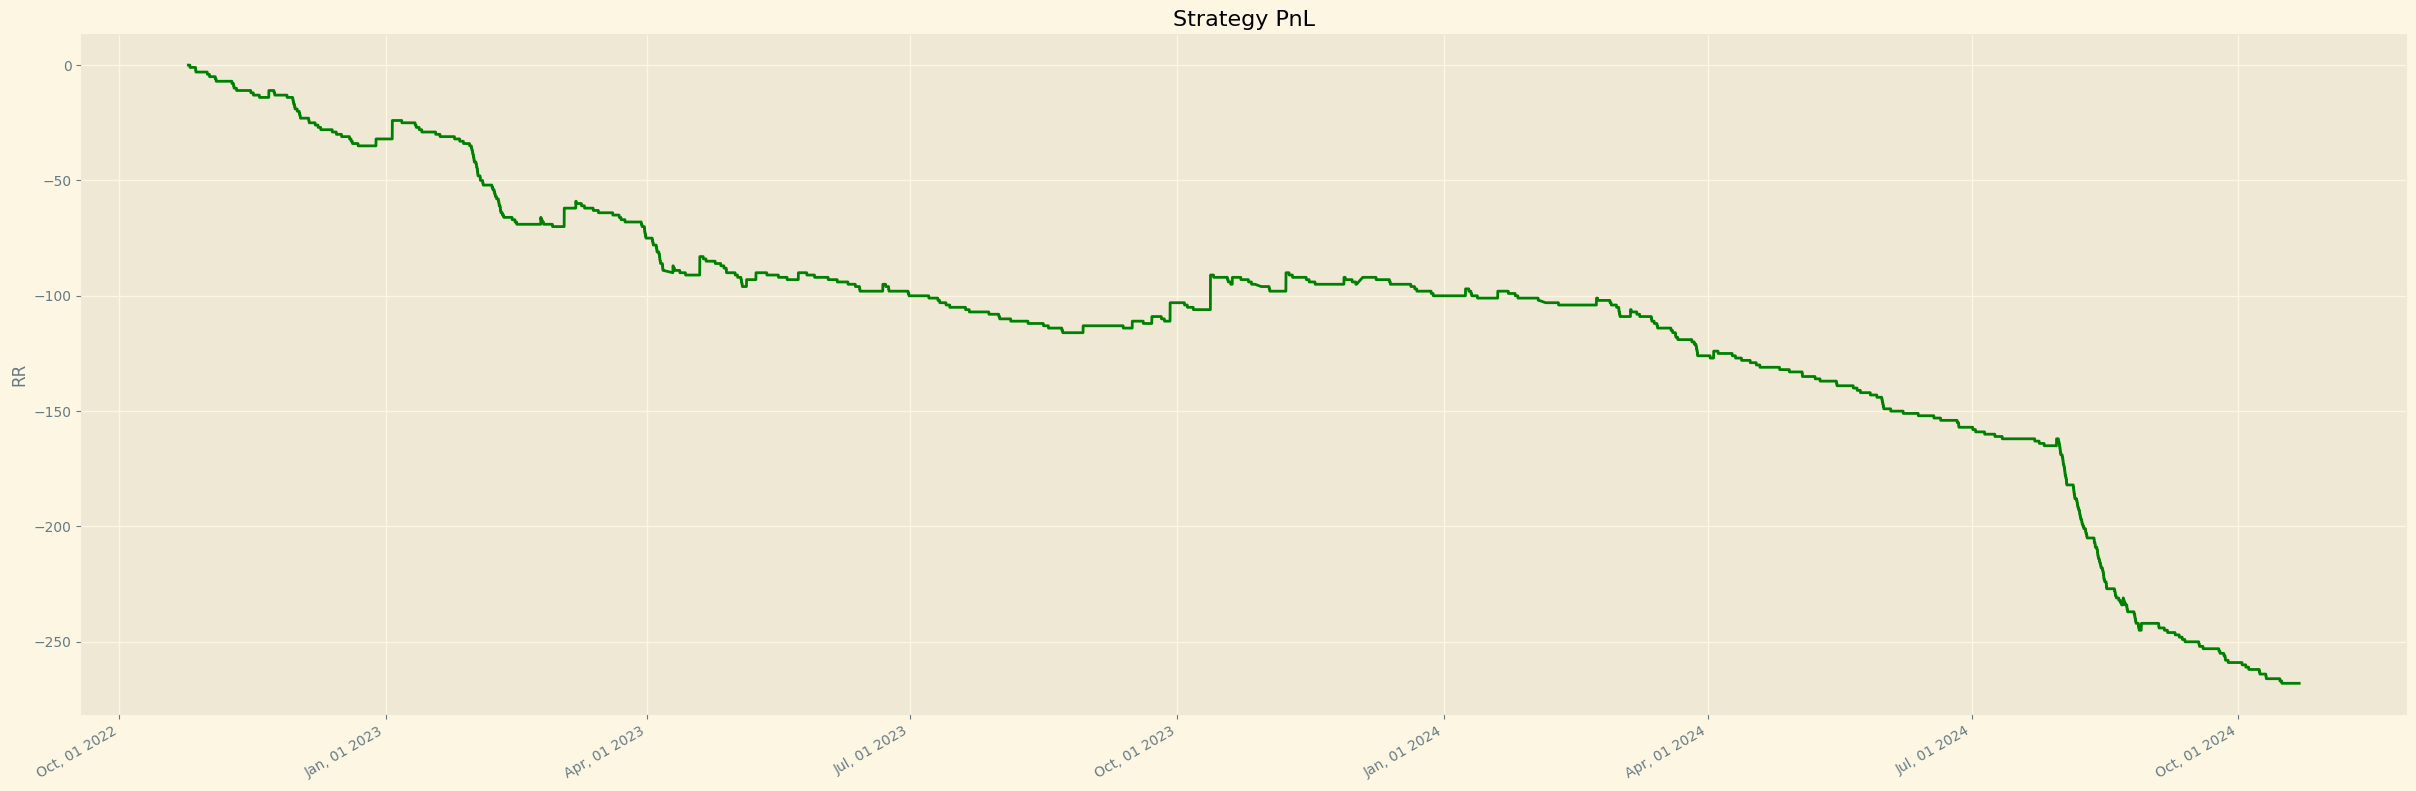

In [15]:
df['Cumulative_PnL'].plot(
        title='Strategy PnL', 
        figsize=FIGSIZE, 
        color='green', 
        xlabel='',
        ylabel='RR',
    )

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mpl_dates.DateFormatter("%b, %d %Y"))

- **Equity Drawdown chart**

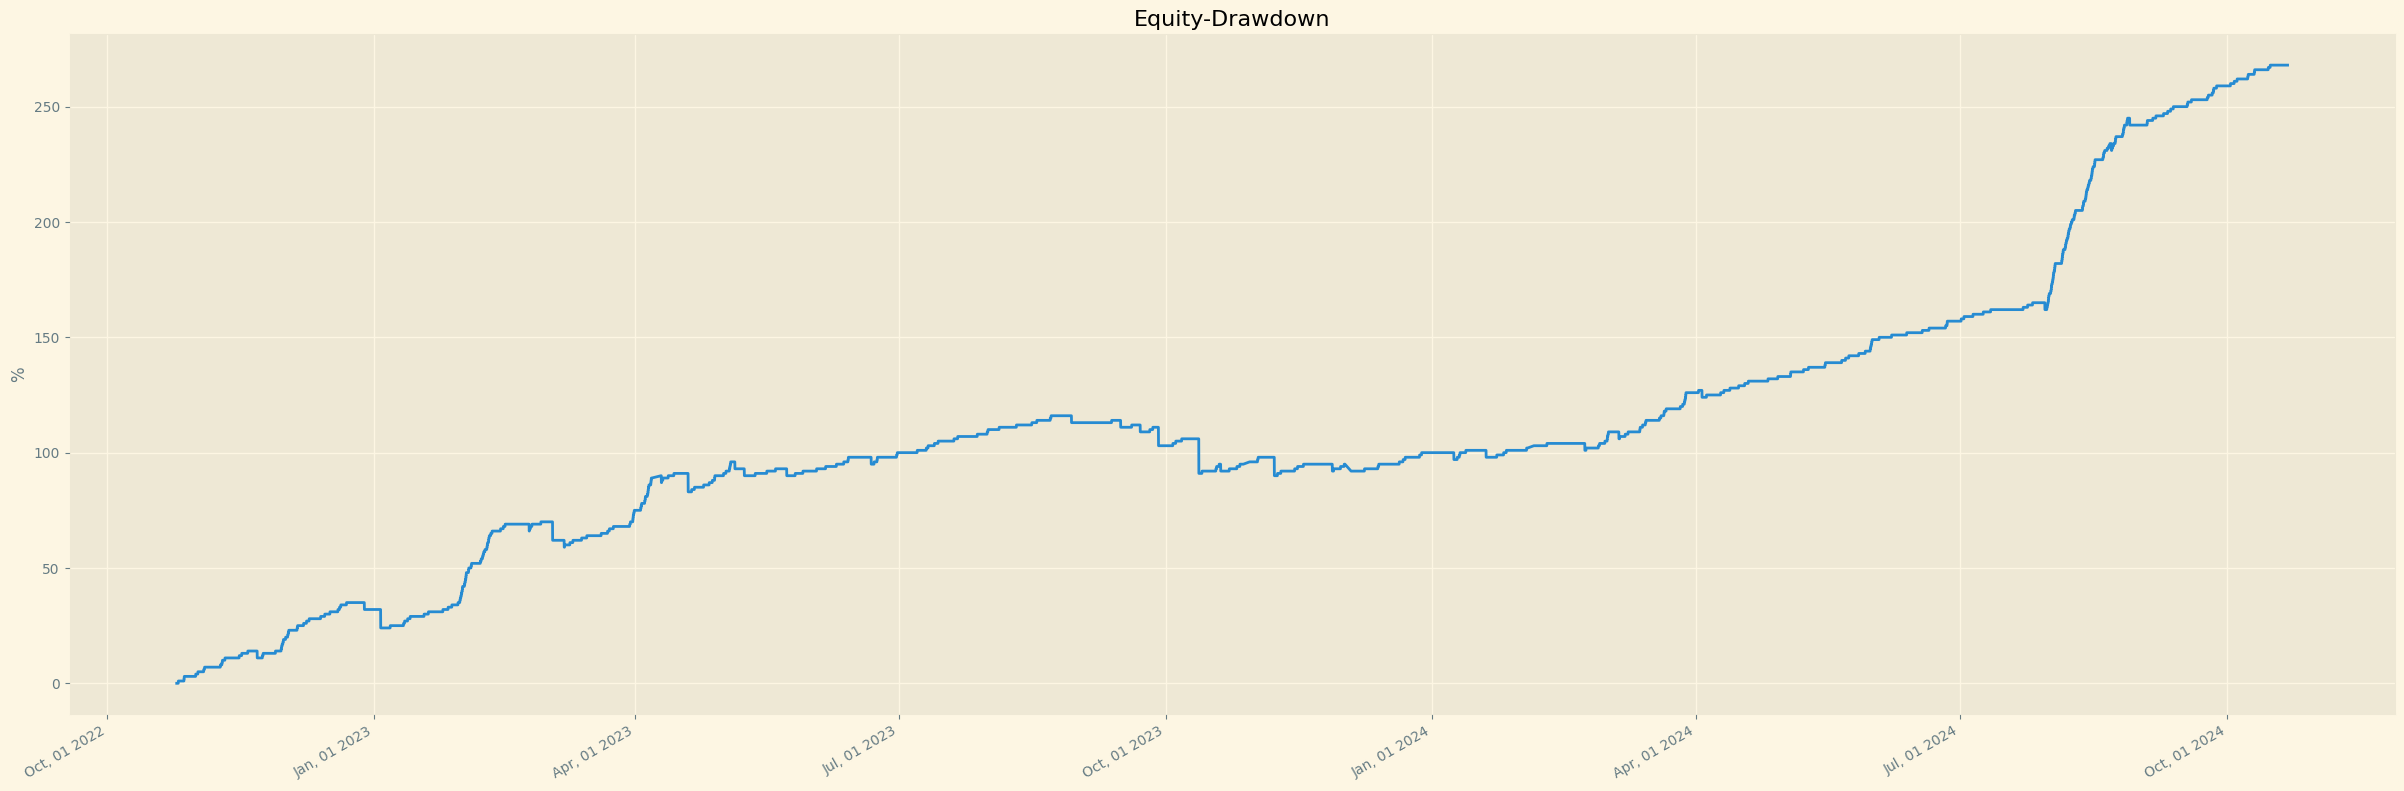

In [16]:
df['Equity'] = df['Cumulative_PnL'] + 100
df['Peak'] = df['Equity'].cummax()

df['Equity-Drawdown'] = (df['Peak'] - df['Equity']) / df['Peak']
# df['Equity-Drawdown'] = np.where(df['Peak'] == 0, abs(df['Equity']), (df['Peak'] - df['Equity']) / df['Peak'])

(df['Equity-Drawdown'] * 100).plot(
    kind='line', 
    figsize=FIGSIZE,
    title="Equity-Drawdown",
    ylabel="%",
    xlabel=''
)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mpl_dates.DateFormatter("%b, %d %Y"))

- **PnL Drawdown chart**

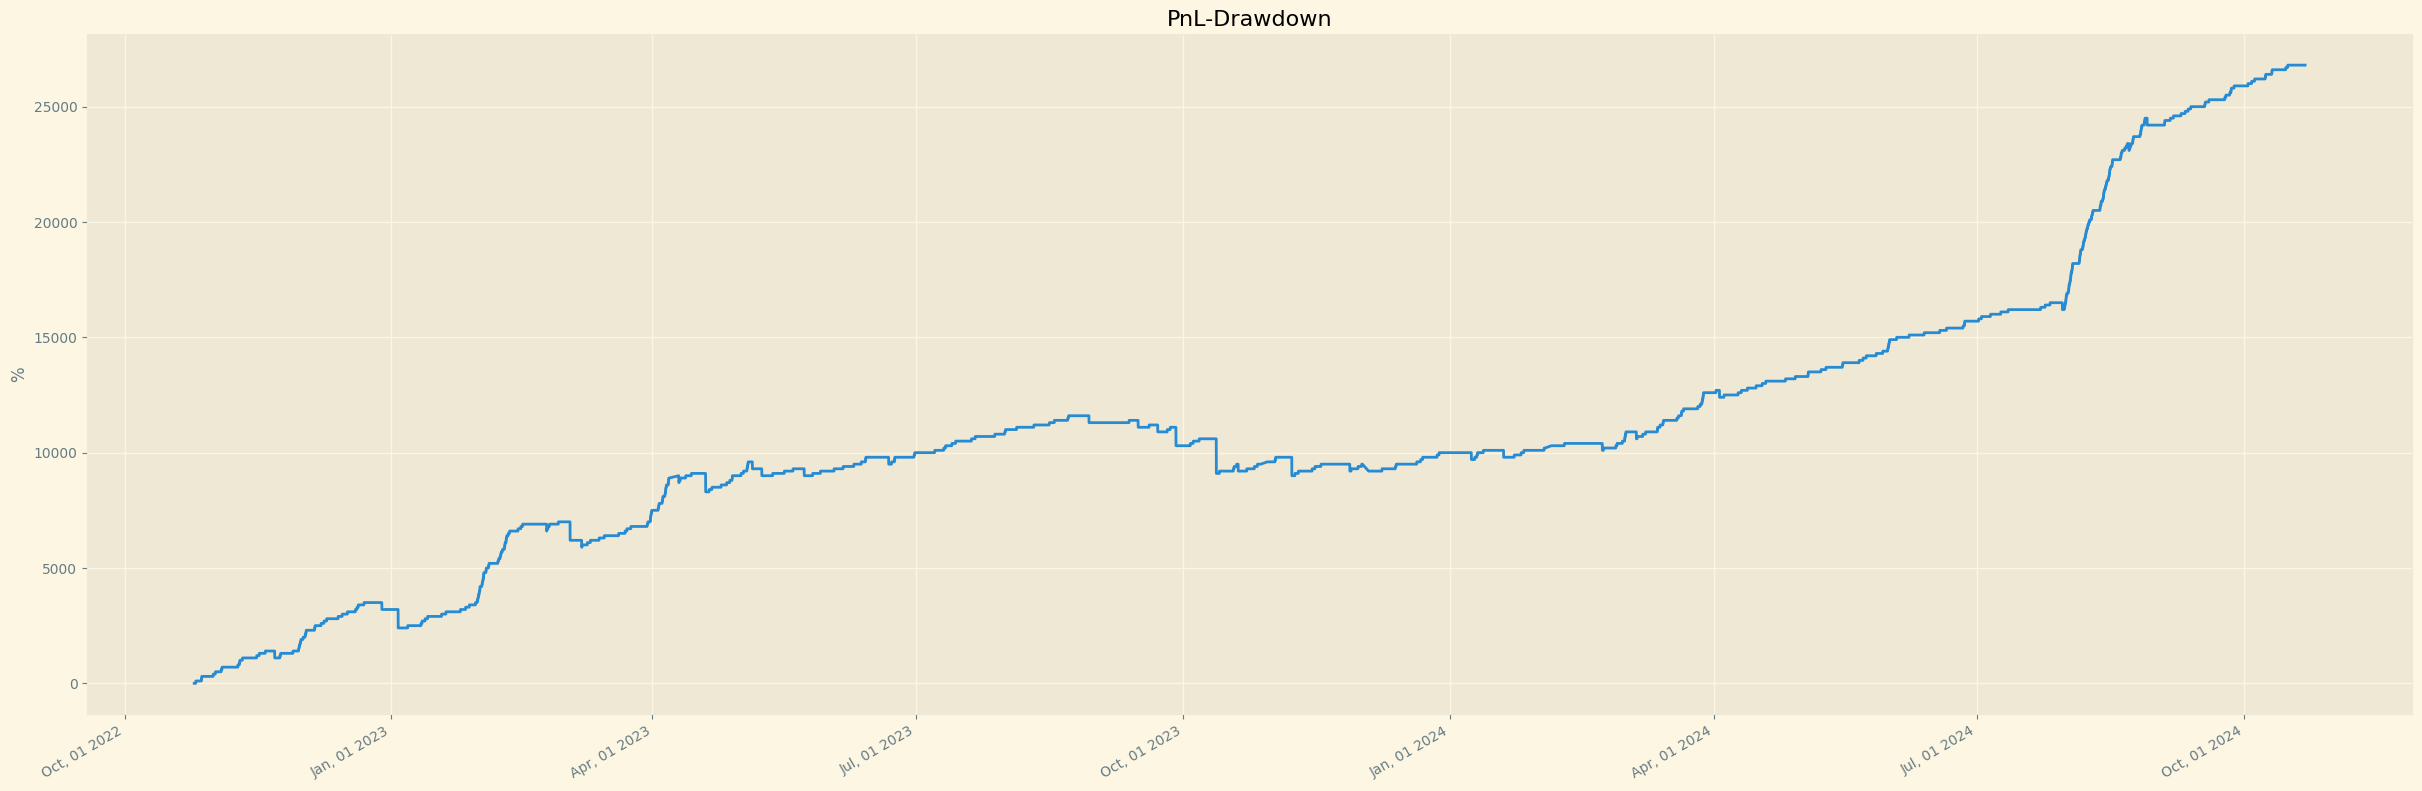

In [17]:
df['Peak'] = df['Cumulative_PnL'].cummax()

df['PnL-Drawdown'] = np.where(df['Peak'] == 0, abs(df['Cumulative_PnL']), (df['Peak'] - df['Cumulative_PnL']) / df['Peak'])

(df['PnL-Drawdown'] * 100).plot(
    kind='line', 
    figsize=FIGSIZE,
    title="PnL-Drawdown",
    ylabel="%",
    xlabel=''
)

plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mpl_dates.DateFormatter("%b, %d %Y"))